In [1]:
import os
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Khai báo tên model, pretrain_model và file cần làm việc

In [3]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

# 2. Khai báo các đường dẫn thư mục làm việc

In [4]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME),
    'EXPORTED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','exported-models',CUSTOM_MODEL_NAME),
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

# 3. Khai báo các đường dẫn file làm việc

In [5]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

## Khởi tạo các đường dẫn thư mục và tải các thư viện cần thiết

In [7]:
for path in paths.values():
    if not os.path.exists(path):
          !mkdir -p {path}

In [9]:
!pip install wget

In [10]:
import wget

### Clone model tensorflow và object_detection

In [11]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {os.path.join(paths['APIMODEL_PATH'])}

Cloning into 'Tensorflow/models'...
remote: Enumerating objects: 96972, done.
remote: Counting objects: 100% (252/252), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 96972 (delta 112), reused 232 (delta 104), pack-reused 96720
Receiving objects: 100% (96972/96972), 611.08 MiB | 17.32 MiB/s, done.
Resolving deltas: 100% (70530/70530), done.


### Cài đặt và giải nén protocol buffer, cài đặt và cấu hình môi trường protocol buffer cho việc sử dụng TensorFlow Object Detection API.

In [12]:
# Install Tensorflow Object Detection
!apt-get install protobuf-compiler
!cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
protobuf-compiler is already the newest version (3.12.4-1ubuntu7.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Processing /content/Tensorflow/models/research
  Preparing metadata (setup.py) ... done
  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)
  Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Using cached keras-3.2.1-py3-none-any.whl (1.1 MB)
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1697356 sha256=07b39f646cf8e6f2c42e3b8d5922ce24faf8c9fc87104325b40c4840d4867636
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ui8679m/wheels/fb/c9/43/709f88e66b36649c7a29812ca4f6236f31caed949aabc3e335
Successfully built object-detection
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.13.0
    Uninstalling tensorboard-2.13.0:
   

### Kiểm tra tất cả thư viện đã tải về thành công

In [15]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

2024-04-15 01:52:01.988821: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 01:52:02.087635: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 01:52:02.088523: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 01:52:04.646884: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Running tests under Python 3.10.12: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
W0415 01:52:17.808838 133348633407488 batch_normalization.py:1531] `tf.keras.layers.experimental.SyncBatchNormalization` endpoint is deprecated and will be removed in a future

In [ ]:
# Tải lại tensorflow với version phù hợp(nếu Verify Installation bị lỗi)
!pip install tensorflow==2.13.0

In [16]:
import object_detection

### Cài đặt và giải nén pretrain_model

In [17]:
!wget {PRETRAINED_MODEL_URL}
!mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
!cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2024-04-15 01:55:27--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.182.207, 64.233.183.207, 173.194.193.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.182.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M   114MB/s    in 0.2s    

2024-04-15 01:55:27 (114 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x32

# 4. Cấu hình và train model

## Tạo label map

In [18]:
labels = [
    {'name':'licence', 'id':1}
]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

## Tạo TF Record

In [19]:
# Giải nén file hình ảnh .tar.gz (Có thể chạy hoặc không)
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [21]:
# Nếu chưa có file TF_RECORD_SCRIPT thì clone về
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

Cloning into 'Tensorflow/scripts'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 1 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.


In [22]:
# Khởi tạo TF Record
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')}
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


## Train custom model

In [23]:
#Copy model config từ file config của pretrain_model
!cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

In [24]:
import tensorflow as tf
from object_detection.utils import config_util

In [25]:
# Đọc tệp pipeline.config và lấy ra tất cả các cấu hình.
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [26]:
# Custom lại model
configs['model'].ssd.num_classes = len(labels)
configs['train_config'].batch_size = 4
configs['train_config'].fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
configs['train_config'].fine_tune_checkpoint_type = "detection"
configs['train_input_config'].label_map_path = files['LABELMAP']
configs['train_input_config'].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
configs['eval_input_configs'][0].label_map_path = files['LABELMAP']
configs['eval_input_configs'][0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [27]:
# Lưu lại custom model vào file config
pipeline_config = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_config, os.path.dirname(files['PIPELINE_CONFIG']))

In [ ]:
# Đường dẫn file train model
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
# Câu lệnh train model
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
# Train model
!{command}

2024-04-14 00:25:37.258104: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
I0414 00:25:42.735474 134993734180864 mirrored_strategy.py:419] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 10000
I0414 00:25:42.783203 134993734180864 config_util.py:552] Maybe overwriting train_steps: 10000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0414 00:25:42.783467 134993734180864 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0414 00:25:42.826125 134993734180864 deprecation.py:364] From /usr/local/lib/python3.10/dist-packages/object_detection/model_lib_v2.py:563: StrategyBase.experimental_distribute_datasets_from_function (from tensorflow.python.distribute.distribute_lib) is 

# 5. Đánh giá model

In [ ]:
#Evaluate the Model
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
!{command}

# 6. Load model và dự đoán

### Cấu hình model dự đoán và xây dựng các hàm dự đoán

In [28]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [29]:
MAIN_FOLDER_PATH = '/content/drive/MyDrive'

In [30]:
# Lấy ra các cấu hình file pipeline_config và xây dựng model dự đoán
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Lấy ra các Checkpoint và tái tạo lại các model dự đoán từ checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(MAIN_FOLDER_PATH, paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

#Xây dựng hàm dự đoán
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image) # Resize ảnh về kích thước phù hợp với config trong model
    prediction_dict = detection_model.predict(image, shapes) # Dự đoán kết quả
    detections = detection_model.postprocess(prediction_dict, shapes) # Xử lý kết quả dự đoán
    return detections

### Dự đoán ảnh

In [31]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [32]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP']) #Tạo danh mục cho các label

In [33]:
IMAGE_PATH = os.path.join(MAIN_FOLDER_PATH, paths['IMAGE_PATH'], 'test', 'MicrosoftTeams-image (1).png')

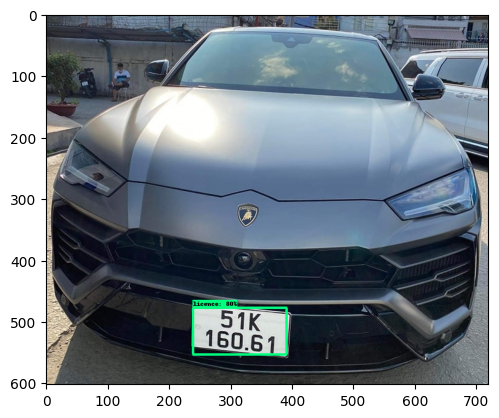

In [34]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset, #Cộng vô để khớp với category_index
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True, #Chuấn hóa về 0 => 1
            max_boxes_to_draw=5, #Tối đa vẽ 5 hình
            agnostic_mode=False) #Tất cả các hộp đều được vẽ cùng màu

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Lưu lại thư mục tensorflow vừa train xong
!mv /content/Tensorflow /content/drive/MyDrive

In [44]:
!rm -rf Tensorflow